In [47]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

from thinkdsp import decorate

# Упражнение 8.1

Блокнот для этой главы — chap08.ipynb. Прочитайте его и запустите код.

В нем есть интерактивный виджет, где можно экспериментировать с параметрами гауссова окна и изучить их влияние на частоту среза.

Что случится, если при увеличении ширины гауссова окна std не увеличивать число элементов в окне M?

In [48]:
from thinkdsp import SquareSignal

def zero_pad(array, n):
    res = np.zeros(n)
    res[:len(array)] = array
    return res


def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency, Hz', ylabel='Amplitude ratio')
    plt.show()


In [49]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from thinkdsp import Wave

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

<ipython-input-50-441d2b238872>:1: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian = scipy.signal.gaussian(M=8, std=8)


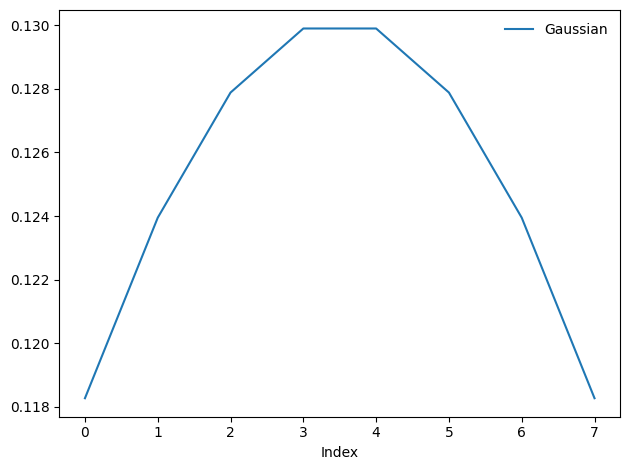

In [50]:
gaussian = scipy.signal.gaussian(M=8, std=8)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

<ipython-input-51-7a926cda5a22>:1: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian = scipy.signal.gaussian(M=8, std=800)


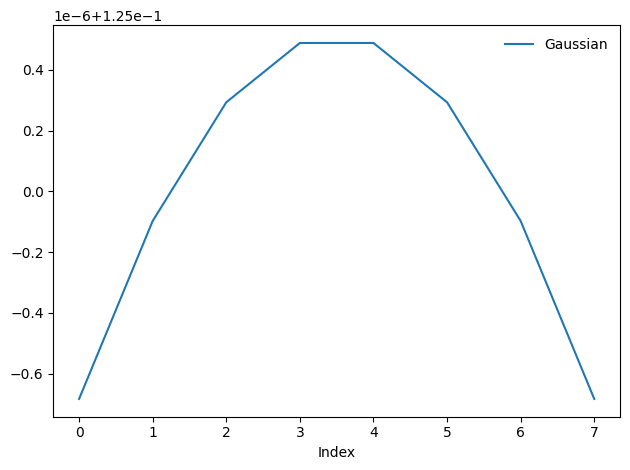

In [51]:
gaussian = scipy.signal.gaussian(M=8, std=800)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

При увеличении std, кривая становится шире, а сам fft уже

# Упражнение 8.2

В этой главе утверждается, что преобразование Фурье гауссовой кривой — также гауссова кривая. Для дискретного преобразования Фурье это сотношение приблизительно верно.

Попробуйте его на нескольких примерах. Что происходит с преобразованием Фурье, если меняется std?

<ipython-input-52-e47084ff132d>:1: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian = scipy.signal.gaussian(M=32, std=2)


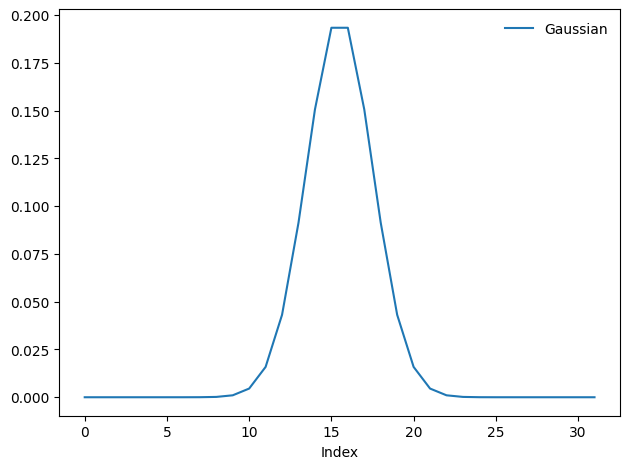

In [52]:
gaussian = scipy.signal.gaussian(M=32, std=2)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

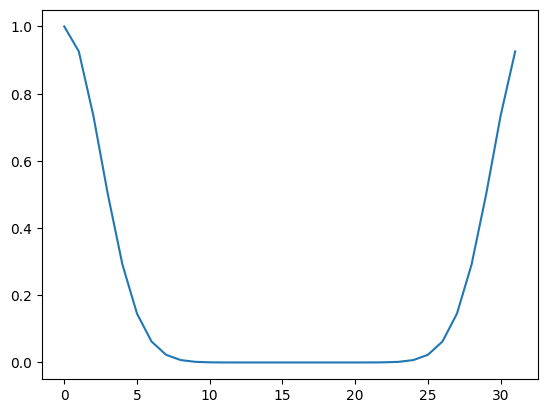

In [53]:
gaussian_fft = np.fft.fft(gaussian)
plt.plot(abs(gaussian_fft), label='Gaussian')

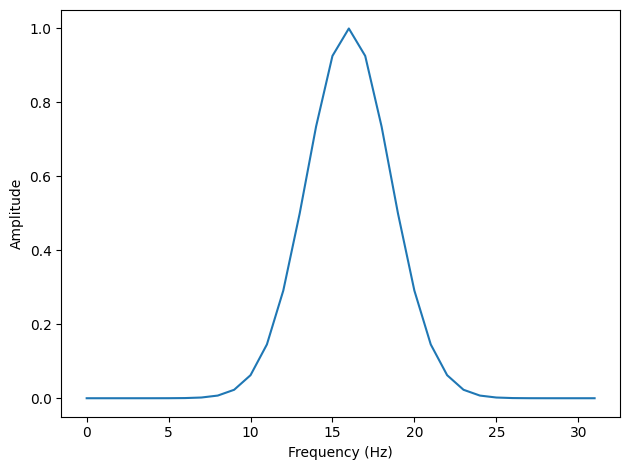

In [54]:
N = len(gaussian)
fft_rolled = np.roll(gaussian_fft, N//2)
plt.plot(abs(fft_rolled))
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

<ipython-input-55-a8f30dde1646>:3: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian = scipy.signal.gaussian(M=M, std=std)


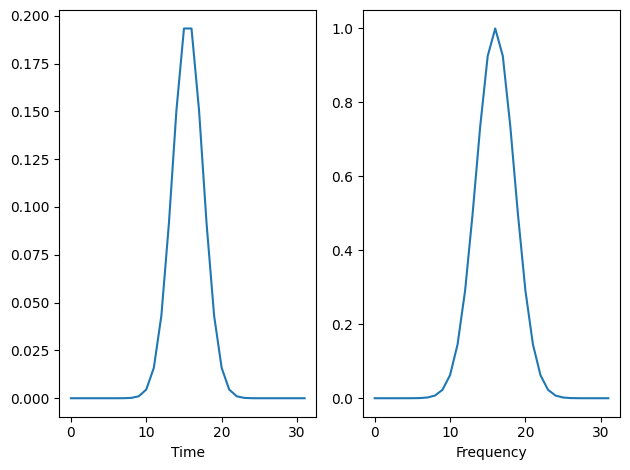

In [55]:
def plot_gaussian(std):
    M = 32
    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    plt.subplot(1, 2, 1)
    plt.plot(gaussian)
    decorate(xlabel='Time')

    fft_gaussian = np.fft.fft(gaussian)
    fft_rolled = np.roll(fft_gaussian, M//2)

    plt.subplot(1, 2, 2)
    plt.plot(np.abs(fft_rolled))
    decorate(xlabel='Frequency')
    plt.show()

plot_gaussian(2)

In [56]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.FloatSlider(min=0.1, max=10, value=2)
interact(plot_gaussian, std=slider);

interactive(children=(FloatSlider(value=2.0, description='std', max=10.0, min=0.1), Output()), _dom_classes=('…

Можно увидеть, что с увеличением std, уривая становится шире, а fft – уже

# Упражнение 8.3

В упражнениях к главе 3 изучалось влияние на утечки спектра окна Хэмминга и некоторых других, предоставляемых NumPy. Глубже понять эти окна можно, изучив их ДПФ.

В дополнение к Гауссову окну, использованному в этой главе, создайте окно Хемминга тех же размеров. Дополните окно нулями и напечатайте его ДПФ. Какое окно больше подходит для фильтра НЧ? Полезно напечатать ДПФ с логарифмическим масштабом по y.

Поэкспериментируйте с разными окнами и разными размерами этих окон.

In [57]:
from thinkdsp import Signal
from thinkdsp import unbias,normalize


class SawtoothSignal(Signal):

    def __init__(self, freq=440, amp=1.0, offset = 0):
        self.freq = freq
        self.amp = amp
        self.offset = offset

    @property
    def period(self): return 1.0 / self.freq

    def evaluate(self,ts):
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

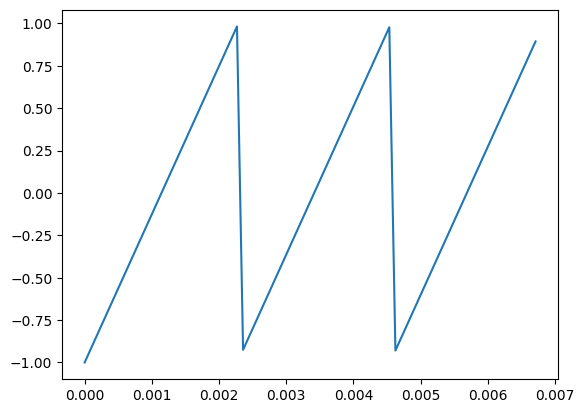

In [58]:
saw_signal = SawtoothSignal()
saw_signal.plot()

In [59]:
wave = saw_signal.make_wave(duration = 0.2,framerate=44100)
wave.make_audio()

In [60]:
M = 30
std = 5

barlett = np.bartlett(M)
blackman = np.blackman(M)
gauss = scipy.signal.gaussian(M,std)
hamming = np.hamming(M)
hanning = np.hanning(M)

<ipython-input-60-4db66957bed5>:6: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gauss = scipy.signal.gaussian(M,std)


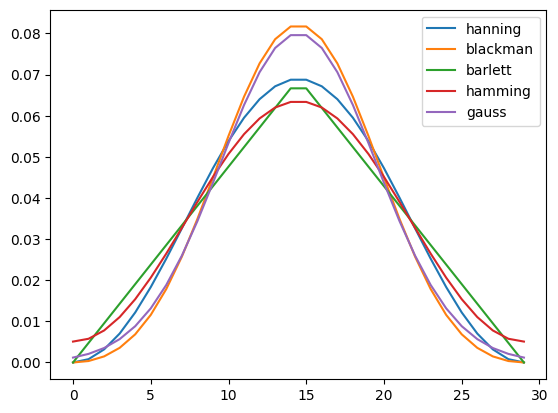

In [61]:
array  = [hanning,blackman,barlett,hamming,gauss]
labels = ['hanning','blackman','barlett','hamming','gauss']

for elem, label in zip(array,labels):
    elem /= sum(elem)
    plt.plot(elem,label=label)
plt.legend()

Посмотрим ДПФ окон:

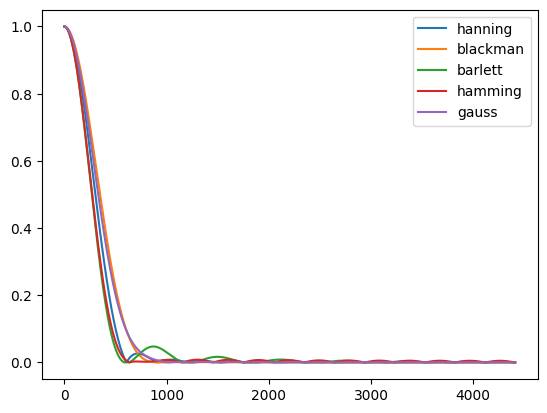

In [62]:
for elem, label in zip(array, labels):
    padded =  zero_pad(elem, len(wave))
    dft_window = np.fft.rfft(padded)
    plt.plot(abs(dft_window), label=label)
plt.legend()

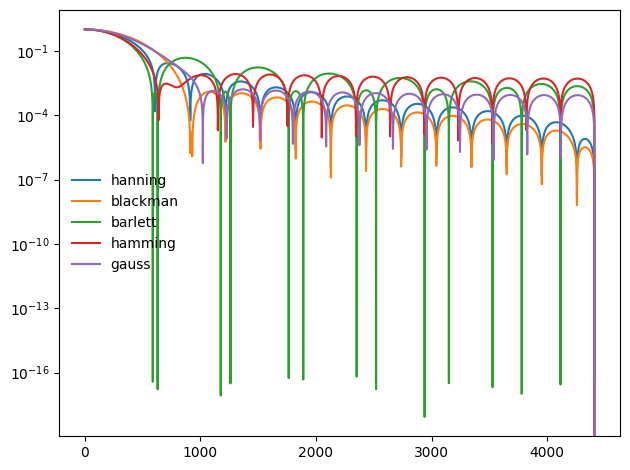

In [63]:
for elem, label in zip(array, labels):
    padded =  zero_pad(elem, len(wave))
    dft_window = np.fft.rfft(padded)
    plt.plot(abs(dft_window), label=label)
plt.legend()
decorate(yscale='log')

Можно увидеть, что Hanning и Hamming спадают быстрее всего. Hanning вновь кажется лучшим.